In [1]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict

from models import VAE


def main(args):

    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ts = time.time()

    dataset = MNIST(
        root='data', train=True, transform=transforms.ToTensor(),
        download=True)
    data_loader = DataLoader(
        dataset=dataset, batch_size=args.batch_size, shuffle=True)

    def loss_fn(recon_x, x, mean, log_var):
        BCE = torch.nn.functional.binary_cross_entropy(
            recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

        return (BCE + KLD) / x.size(0)

    vae = VAE(
        encoder_layer_sizes=args.encoder_layer_sizes,
        latent_size=args.latent_size,
        decoder_layer_sizes=args.decoder_layer_sizes,
        conditional=args.conditional,
        num_labels=10 if args.conditional else 0).to(device)

    optimizer = torch.optim.Adam(vae.parameters(), lr=args.learning_rate)

    logs = defaultdict(list)

    for epoch in range(args.epochs):

        tracker_epoch = defaultdict(lambda: defaultdict(dict))

        for iteration, (x, y) in enumerate(data_loader):

            x, y = x.to(device), y.to(device)

            if args.conditional:
                recon_x, mean, log_var, z = vae(x, y)
            else:
                recon_x, mean, log_var, z = vae(x)

            for i, yi in enumerate(y):
                id = len(tracker_epoch)
                tracker_epoch[id]['x'] = z[i, 0].item()
                tracker_epoch[id]['y'] = z[i, 1].item()
                tracker_epoch[id]['label'] = yi.item()

            loss = loss_fn(recon_x, x, mean, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            logs['loss'].append(loss.item())

            if iteration % args.print_every == 0 or iteration == len(data_loader)-1:
                print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                    epoch, args.epochs, iteration, len(data_loader)-1, loss.item()))

                if args.conditional:
                    c = torch.arange(0, 10).long().unsqueeze(1).to(device)
                    z = torch.randn([c.size(0), args.latent_size]).to(device)
                    x = vae.inference(z, c=c)
                else:
                    z = torch.randn([10, args.latent_size]).to(device)
                    x = vae.inference(z)

                plt.figure()
                plt.figure(figsize=(5, 10))
                for p in range(10):
                    plt.subplot(5, 2, p+1)
                    if args.conditional:
                        plt.text(
                            0, 0, "c={:d}".format(c[p].item()), color='black',
                            backgroundcolor='white', fontsize=8)
                    plt.imshow(x[p].view(28, 28).cpu().data.numpy())
                    plt.axis('off')

                if not os.path.exists(os.path.join(args.fig_root, str(ts))):
                    if not(os.path.exists(os.path.join(args.fig_root))):
                        os.mkdir(os.path.join(args.fig_root))
                    os.mkdir(os.path.join(args.fig_root, str(ts)))

                plt.savefig(
                    os.path.join(args.fig_root, str(ts),
                                 "E{:d}I{:d}.png".format(epoch, iteration)),
                    dpi=300)
                plt.clf()
                plt.close('all')

        df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
        g = sns.lmplot(
            x='x', y='y', hue='label', data=df.groupby('label').head(100),
            fit_reg=False, legend=True)
        g.savefig(os.path.join(
            args.fig_root, str(ts), "E{:d}-Dist.png".format(epoch)),
            dpi=300)
        # Save the trained variational autoencoder model
        torch.save(vae.state_dict(), os.path.join(
            'models', "cvae.pth"))



In [ ]:
if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--learning_rate", type=float, default=0.001)
    parser.add_argument("--encoder_layer_sizes", type=list, default=[784, 256])
    parser.add_argument("--decoder_layer_sizes", type=list, default=[256, 784])
    parser.add_argument("--latent_size", type=int, default=2)
    parser.add_argument("--print_every", type=int, default=937)
    parser.add_argument("--fig_root", type=str, default='figures')
    parser.add_argument("--conditional", action='store_true')

    args = parser.parse_args()

    # Fix: Ensure fig_root is a directory, not a file path
    if not os.path.isdir(args.fig_root):
        args.fig_root = 'figures'
    main(args)

ValueError: unknown action "store_ture"

In [ ]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict

from models import VAE
parser = argparse.ArgumentParser()
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--epochs", type=int, default=10)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--learning_rate", type=float, default=0.001)
parser.add_argument("--encoder_layer_sizes", type=list, default=[784, 256])
parser.add_argument("--decoder_layer_sizes", type=list, default=[256, 784])
parser.add_argument("--latent_size", type=int, default=2)
parser.add_argument("--print_every", type=int, default=937)
parser.add_argument("--fig_root", type=str, default='figures')
parser.add_argument("--conditional", action='store_false')

args = parser.parse_args()

# Fix: Ensure fig_root is a directory, not a file path
if not os.path.isdir(args.fig_root):
    args.fig_root = 'figures'


In [ ]:
#load the trained model
# args.conditional = True  # Set to True for CVAE, False for VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(
    encoder_layer_sizes=args.encoder_layer_sizes,
    latent_size=args.latent_size,
    decoder_layer_sizes=args.decoder_layer_sizes,
    conditional=args.conditional,
    num_labels=10 if args.conditional else 0).to(device)
vae.load_state_dict(torch.load(os.path.join(os.path.join(
            'models', "vae.pth"))))


<All keys matched successfully>

In [ ]:
dataset = MNIST(
        root='data', train=True, transform=transforms.ToTensor(),
        download=True)
data_loader = DataLoader(
        dataset=dataset, batch_size=args.batch_size, shuffle=True)

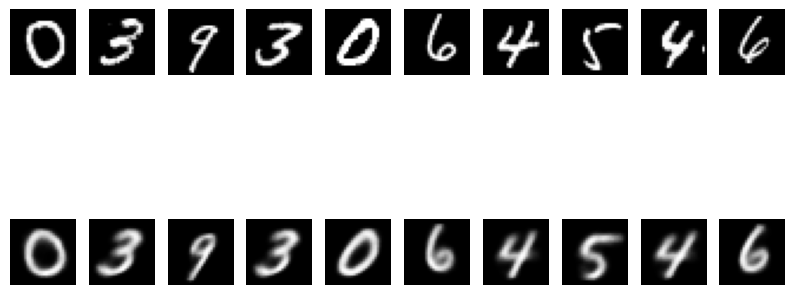

In [ ]:
# inference using the trained model and visualize the results
for x, y in data_loader:
    x, y = x.to(device), y.to(device)

    if args.conditional:
        recon_x, mean, log_var, z = vae(x, y)
    else:
        recon_x, mean, log_var, z = vae(x)

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(x[i].view(28, 28).cpu().data.numpy(), cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, i + 11)
        plt.imshow(recon_x[i].view(28, 28).cpu().data.numpy(), cmap='gray')
        plt.axis('off')
    plt.show()
    break